<a href="https://colab.research.google.com/github/miura-katsuyoshi/VerilogSimulation.ipynb/blob/main/VerilogSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!apt install iverilog

Reading package lists... Done
Building dependency tree       
Reading state information... Done
iverilog is already the newest version (10.1-0.1build1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [27]:
verilog_source = """
// Simple counter example
`timescale 1ns/1ns
module main;
    reg clk;
    reg rst_n;
    reg [2:0] data;
 
    initial clk = 1'b1;
    always #5 clk = ~clk;
 
    initial begin
        $display("time,clk,rst_n,data*,data[2],data[1],data[0]");
        $monitor("%t,%b,%b,%d,%b,%b,%b", $realtime, clk, rst_n, data, data[2], data[1], data[0]);
        rst_n <= 1'b0;
        repeat(2) @(posedge clk);
        rst_n <= 1'b1;
        repeat(10) @(posedge clk);
        $finish ;
    end
 
    always @(posedge clk or negedge rst_n) begin
        if(~rst_n) data <= 8'd0;
        else data <= data + 1;
    end
endmodule
"""

with open("main.v", "wt") as f:
  f.write(verilog_source)

!iverilog -o main main.v
!vvp main | tee graph.txt

time,clk,rst_n,data*,data[2],data[1],data[0]
                   0,1,0,0,0,0,0
                   5,0,0,0,0,0,0
                  10,1,0,0,0,0,0
                  15,0,0,0,0,0,0
                  20,1,1,0,0,0,0
                  25,0,1,0,0,0,0
                  30,1,1,1,0,0,1
                  35,0,1,1,0,0,1
                  40,1,1,2,0,1,0
                  45,0,1,2,0,1,0
                  50,1,1,3,0,1,1
                  55,0,1,3,0,1,1
                  60,1,1,4,1,0,0
                  65,0,1,4,1,0,0
                  70,1,1,5,1,0,1
                  75,0,1,5,1,0,1
                  80,1,1,6,1,1,0
                  85,0,1,6,1,1,0
                  90,1,1,7,1,1,1
                  95,0,1,7,1,1,1
                 100,1,1,0,0,0,0
                 105,0,1,0,0,0,0
                 110,1,1,1,0,0,1
                 115,0,1,1,0,0,1
                 120,1,1,2,0,1,0


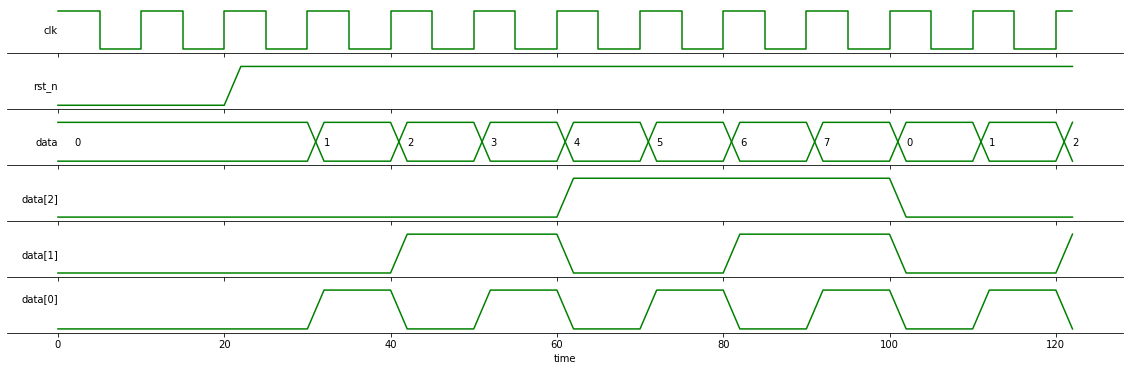

In [28]:
TRANSITION_TIME = 2.0 # 遷移時間（立ち上がり時間、立ち下がり時間）但し、"clk" は常に遷移時間=0
GRAPH_WIDTH = 20.0    # グラフの横幅
GRAPH_HEIGHT = 1.0    # グラフの高さ（波形１つ分）
GRAPH_COLOR = "green" # 波形の色

import matplotlib.pyplot as plt
import numpy as np

with open("graph.txt") as f:
  monitor_output = f.readlines()

while "" in monitor_output:
  monitor_output.remove("")
for i in range(len(monitor_output)):
  monitor_output[i] = monitor_output[i].split(',')
signal_names = monitor_output.pop(0)
is_multibit = [name[-1]=="*" for name in signal_names]
for j in range(len(signal_names)):
  if signal_names[j][-1]=="*":
    signal_names[j] = signal_names[j][0:-1]
  else:
    for i in range(len(monitor_output)):
      monitor_output[i][j] = int(monitor_output[i][j])
num_signals = len(signal_names) - 1

plt.figure(figsize=(GRAPH_WIDTH, num_signals * GRAPH_HEIGHT))
for j in range(1,num_signals+1):
  ax = plt.subplot(num_signals, 1, j)
  ax.yaxis.set_ticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.text(0, 0.4, signal_names[j], horizontalalignment="right")
  ax.set_ylim(-0.1,1.1)
  if j < num_signals:
    plt.setp(ax.get_xticklabels(), visible=False)
  else:
    ax.set_xlabel(signal_names[0])
  if is_multibit[j]:
    x = [monitor_output[0][0]]
    y0 = [0]
    y1 = [1]
    ax.text(TRANSITION_TIME, 0.4, monitor_output[0][j])
    for i in range(1,len(monitor_output)):
      x.append(monitor_output[i][0])
      y0.append(y0[-1])
      y1.append(y1[-1])
      if  i < len(monitor_output) - 1 and monitor_output[i][0] + TRANSITION_TIME >= monitor_output[i+1][0]:
        x.append(monitor_output[i+1][0])
      else:
        x.append(monitor_output[i][0]+TRANSITION_TIME)
      if monitor_output[i][j]!=monitor_output[i-1][j]:
        y0.append(1-y0[-1])
        y1.append(1-y1[-1])
        ax.text(x[-1], 0.4, monitor_output[i][j])
      else:
        y0.append(y0[-1])
        y1.append(y1[-1])
    plt.plot(x, y0, color=GRAPH_COLOR)
    plt.plot(x, y1, color=GRAPH_COLOR)
  else:
    x = [monitor_output[0][0]]
    y = [monitor_output[0][j]]
    for i in range(1,len(monitor_output)):
      x.append(monitor_output[i][0])
      y.append(monitor_output[i-1][j])
      if signal_names[j]=="clk":
        x.append(monitor_output[i][0])
      elif  i < len(monitor_output) - 1 and monitor_output[i][0] + TRANSITION_TIME >= monitor_output[i+1][0]:
        x.append(monitor_output[i+1][0])
      else:
        x.append(monitor_output[i][0]+TRANSITION_TIME)
      y.append(monitor_output[i][j])
    x.append(monitor_output[-1][0]+TRANSITION_TIME)
    y.append(monitor_output[-1][j])
    plt.plot(x, y, color=GRAPH_COLOR)

plt.show()
# plt.savefig("waveform.svg", format="svg")   # グラフをPNG形式で保存したい場合は、plt.show() をコメントアウトし、この行を有効に
# plt.savefig("waveform.png", format="png")   # グラフをSVG形式で保存したい場合は、plt.show() をコメントアウトし、この行を有効に
